In [538]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy import signal
from numpy import trapz
from typing import Optional, List, Dict, Tuple

import matplotlib.pyplot as plt
from CGRtools import smiles
%config IPCompleter.use_jedi = False
from numpy import trapz
from lmfit.models import GaussianModel, ExponentialGaussianModel, LinearModel
from lmfit.model import ModelResult

import plotly.graph_objects as go
import plotly.express as px
import plotly

In [ ]:
def _fit_gauss_to_peak(self, wl_index:Optional[int]=None, peak_index:int=0)->ModelResult:
        """Function that fit a Gaussian into the given peak on a given WL index. Uses lmfit.GaussianModel.
        Uses previously calculate baselines.

        Parameters
        ----------
        wl_index : int, optional
            if given, will scan the intensity at this index
        peak_index : int, optinal
            if given, calculates the index to scan instead. 0 by default

        Returns
        -------
        ModelResult
            a fitted Gaussian function
        """
        wl_index = self._optional(wl_index, self.peaks["wl_index"])
        
        gmodel = GaussianModel()
        params = gmodel.make_params(center=self.peaks["peaks"][peak_index], 
                                    amplitude=self.intensity.loc[self.peaks["peaks"][peak_index],wl_index], 
                                    sigma=5)
        x = self.intensity.loc[self.peaks["left"][peak_index]:self.peaks["right"][peak_index],wl_index].index
        y = self.intensity.loc[self.peaks["left"][peak_index]:self.peaks["right"][peak_index],wl_index] - self.gaussians["baselines"][peak_index].eval(x = x)
        result = gmodel.fit(y, params, x=x)
        return result
    
def _fit_baseline_to_peak(self, peak_index:Optional[int]=None, wl_index:Optional[int]=None)->ModelResult:
        """Function that fit a linear function to represent a basline of a given peak at a given WL index. 
        Uses lmfit.GaussianModel.
        Linear function are fitted by the left and right local minima around the peak.

        Parameters
        ----------
        wl_index : int, optional
            if given, will scan the intensity at this index
        peak_index : int, optinal
            if given, calculates the index to scan instead. 0 by default

        Returns
        -------
        ModelResult
            a fitted Gaussian function
        """
        wl_index = self._optional(wl_index, self.peaks["wl_index"])
        lmodel = LinearModel()
        x = self.intensity.loc[self.peaks["left"][peak_index]:self.peaks["right"][peak_index],wl_index].index
        y = self.intensity.loc[self.peaks["left"][peak_index]:self.peaks["right"][peak_index],wl_index]
        result = lmodel.fit([list(y)[0]]+[list(y)[-1]], x=[list(x)[0]]+[list(x)[-1]])
        return result

In [871]:
class Peak:
    def __init__(self, wl_index:int, center:int, left:int, right:int):
        self.wl_index:int = wl_index
        self.center:int = center
        self.left:int = left
        self.right:int = right
        self.gaussian_left:int = left
        self.gaussian_right:int = right
        self.gaussian:ModelResult = None
        self.baseline:ModelResult = None
        self.area:float = 0
        self.ignored = False
        
    def fit_baseline(self, intensity:DataFrame):
        lmodel = LinearModel()
        x = intensity.loc[self.left:self.right,self.wl_index].index
        y = intensity.loc[self.left:self.right,self.wl_index]
        self.baseline = lmodel.fit([list(y)[0]]+[list(y)[-1]], x=[list(x)[0]]+[list(x)[-1]])
        
    def fit_gaussian(self, intensity:DataFrame):
        gmodel = GaussianModel()
        params = gmodel.make_params(center=self.center, 
                                    amplitude=intensity.loc[self.center,self.wl_index], 
                                    sigma=5)
        x = intensity.loc[self.left:self.right,self.wl_index].index
        y = intensity.loc[self.left:self.right,self.wl_index] - self.baseline.eval(x = x)
        self.gaussian = gmodel.fit(y, params, x=x)
        self.gaussian_left = int(self.gaussian.params["center"].value - 3*self.gaussian.params["sigma"].value)
        self.gaussian_right = int(self.gaussian.params["center"].value + 3*self.gaussian.params["sigma"].value)
            
        
    def calculate_area(self, intensity:DataFrame, time_interval:float=1, cut:bool=False):
        x = self.gaussian.data.index
        if cut:
            gauss_left = list(x).index(int(self.gaussian.params["center"].value - 3*self.gaussian.params["sigma"].value))
            gauss_right = list(x).index(int(self.gaussian.params["center"].value + 3*self.gaussian.params["sigma"].value))
            approx = self.gaussian.eval()[gauss_left:gauss_right] 
        else:
            approx = self.gaussian.eval()
        self.area = trapz(approx, dx=time_interval)
    
    

In [876]:
class Chromatogram:
    def __init__(self, filename:str, base_chromatogram:Chromatogram=None):
        self.filename:str = filename
        self.intensity:DataFrame = pd.read_table(filename, delimiter="\t", skiprows=12, header=None)
        self.intensity = self.intensity.fillna(0)
        self.peaks:Dict[int, Peak] = {}
        self.ignored_peaks:Dict[int, Peak] = {}
        self.ratios:Dict[int, float] = {}
        self.calibration:Dict[int, float] = {}
        self.base_chromatogram = base_chromatogram
        
        with open(filename) as f:
            self.datatype = f.readline().strip().split("\t")[1]
            self.time_interval = float(f.readline().strip().split("\t")[1][:-4])/1000
            self.wl_interval = float(f.readline().strip().split("\t")[1][:-2])
            self.start_time = float(f.readline().strip().split("\t")[1][:-3])
            self.end_time = float(f.readline().strip().split("\t")[1][:-3])
            self.start_wl = float(f.readline().strip().split("\t")[1][:-2])
            self.end_wl = float(f.readline().strip().split("\t")[1][:-2])
            self.time_points = int(f.readline().strip().split("\t")[1])
            self.wl_points = int(f.readline().strip().split("\t")[1])
            self.new_pda = eval(f.readline().strip().split("\t")[1].capitalize())
            self.intensity_unit = f.readline().strip().split("\t")[1]
            
    def _optional(self, value, default):
        """Helper function that sets the optional value with given or default.

        Parameters
        ----------
        value : Any
            the argument of the function that is checked against None
        default : Any
            A default value to return if the given argument is None

        Returns
        -------
        Any
            given value, or default value if None is given
        """
        if value is None:
            return default
        else:
            return value
            
    def calculate_peaks(self, wl_index:Optional[int]=None, wl:Optional[int]=None, height_diff:float=0.3):
        """Function that scans the chromatogram intensity at given index or wavelength to identify peaks.
        Creates a class atribute "peaks" as a dictionary with the following information:
        - "wl_index": The Wl index at which the peaks were found;
        - "peaks": centers of the peaks;
        - "left" and "right": local minima to the left and right side of the peak.

        Parameters
        ----------
        wl_index : int, optional
            if given, will scan the intensity at this index. 0 by default
        wl : int, optinal
            if given, calculates the index to scan instead
        height_diff: float
            determines the minimum height of peaks to detect, related to the highest intensity

        Returns
        -------
        None
        """
        wl_index = self._optional(wl_index, 0)
        if wl is not None:
            wl_index = int((wl-self.start_wl)/self.wl_interval)
        #
        peaks, properties = signal.find_peaks(self.intensity[wl_index],
                                              prominence=self.intensity[wl_index].max()*height_diff)
        mins = signal.argrelextrema(np.array(self.intensity[wl_index]), comparator=np.less_equal, order=10)[0]
        right_sides = np.searchsorted(mins, peaks, side="right")
        for i in range(len(peaks)):
            self.peaks[i] = Peak(wl_index, list(self.intensity[wl_index].index[peaks])[i],
                            list(self.intensity[wl_index].index[mins[right_sides-1]])[i],
                            list(self.intensity[wl_index].index[mins[right_sides]])[i])
            if self.base_chromatogram is not None:
                not_found = True
                for ind, p in self.base_chromatogram.peaks.items():
                    if p.left<self.peaks[i].center<p.right:
                        not_found = False
                        self.peaks[ind] = self.peaks[i]
                        break
                if not_found:
                    self.ignore_peak(i)
                if i not in self.base_chromatogram.peaks.keys():
                    self.ignore_peak(i)
        
    def ignore_peak(self, peak_index):
        """Function that removes the peak from the list of peaks.

        Parameters
        ----------
        peak_index : int
            Removes peak information (center, left, and right) at the given position (index)

        Returns
        -------
        None
        """
        self.ignored_peaks[peak_index] = self.peaks.pop(peak_index)
            
    def fit_all_peaks(self):
        """Function that fits a baseline and a Gaussian into every peak.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        for ind, peak in self.peaks.items():
            peak.fit_baseline(self.intensity)
            peak.fit_gaussian(self.intensity)
        
    def cut_time(self, before:Optional[int]=None, after:Optional[int]=None, unit:str="s"):
        """Function that cuts the rows of the intensity table before and/or after a given point.

        Parameters
        ----------
        before : int, optional
            if given, remove any points before this one
        after : int, optional
            if given, remove any points after this one
        unit : str, "s" or "p"
            if "s", will consider time in seconds, thus recalculating the position with the Chromatogram's time interval
            otherwise, considers only indices in the table

        Returns
        -------
        None
        """
        
        if before and unit=="s":
            before = int(before/self.time_interval)
        if not before:
            before = 0
        if after and unit == "s":
            after = int(after/self.time_interval)
        if not after:
            after = self.intensity.shape[0]
        self.intensity = self.intensity.loc[range(before, after)]
        
    def calibrate(self, calibration_values:Dict[int,float]):
        for k, v in calibration_values.items():
            if type(k) is tuple:
                coefficient = v/100./sum([self.ratios[i] for i in k])
                for i in k:
                    self.calibration[i] = coefficient
            else:
                coefficient = v/100./self.ratios[k]
                self.calibration[k] = coefficient
                
    def calculate_calibrated_ratios(self, external_calibration_values:Optional[Dict[int,float]]=None):
        calibrated_ratios = []
        if external_calibration_values is not None:
            ratio_sum = 0
            for ind, ratio in self.ratios.items():
                self.ratios[ind] = ratio*external_calibration_values[ind]
                ratio_sum += ratio*external_calibration_values[ind]
            if ratio_sum>1:
                for ind in self.ratios.keys():
                    self.ratios[ind] = self.ratios[ind]/ratio_sum
        else:
            
            for ind, coef in self.calibration.items():
                self.ratios[ind] = self.ratios[ind]*coef
    
    def calculate_areas(self, cut:bool=False)->float:
        """Function that calculates the area of all peaks using their Gaussian functions. Uses numpy.trapz.

        Parameters
        ----------
        cut: bool
            if given, will cut the Gaussian at +-3*sigma. False by default
        Returns
        -------
        List(float)
            the areas of all the peaks
        """
        areas = []
        for ind, peak in self.peaks.items():
            peak.calculate_area(self.intensity, self.time_interval, cut)
            areas.append(peak.area)
        return areas
    
    def calculate_ratios(self, cut:bool=False)->List[float]:
        """Function that calculates the area ratios of all peaks at a given WL index using the Gaussian function. 

        Parameters
        ----------
        cut: bool
            if given, will cut the Gaussian at +-3*sigma. False by default
        Returns
        -------
        List[float]
            the ratios of areas of all peaks
        """
        areas = self.calculate_areas()
        for i in self.peaks.keys():
            self.ratios[i] = self.peaks[i].area/sum(areas)
        return self.ratios
    
    def calculate_er(self, enantiomers:Tuple[int])->List[float]:
        return [self.peaks[i].area/sum([self.peaks[j].area for j in enantiomers]) for i in enantiomers]

    def plot(self, wl_index:Optional[int]=None, peaks:bool=False, gaussians:bool=False, cut:bool=False):
        def hex_to_rgb(hex_color: str) -> tuple:
            hex_color = hex_color.lstrip("#")
            if len(hex_color) == 3:
                hex_color = hex_color * 2
            return int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        wl_index = self._optional(wl_index, self.peaks[0].wl_index)
        fig = go.Figure()

        colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']

        fig.add_trace(go.Scatter(x=self.intensity[wl_index].index, y=self.intensity[wl_index], 
                                 name="chromatogram",
                                 line_shape='linear',
                                 line_color="black",
                                 hovertemplate=None
                                    ))
        if peaks:
            for i, p in self.peaks.items():
                fig.add_trace(go.Scatter(x=[p.center], y=[self.intensity.loc[p.center,wl_index]], 
                                     name="Peak "+str(i),mode='markers', 
                                     marker=dict(
                                        symbol="triangle-down",
                                        size=15,
                                        color=colors[i] #set color equal to a variable
                                     ),
                                     customdata=np.dstack((["Peak "+str(i)],
                                                           [p.center*self.time_interval],
                                                           [p.area],
                                                           [self.ratios[i]])),
                                     hovertemplate='<b>%{customdata[0][0]}</b><br>center: %{customdata[0][1]:.1f}s<br>area: %{customdata[0][2]:f}<br>ratio: %{customdata[0][3]:.1%}'))
                fig.add_trace(go.Scatter(x=[p.left], y=[self.intensity.loc[p.left,wl_index]], 
                                     name="Peak "+str(i),mode='markers', 
                                     marker=dict(
                                        symbol="triangle-up",
                                        size=15,
                                        color=colors[i] #set color equal to a variable
                                     )))
                fig.add_trace(go.Scatter(x=[p.right], y=[self.intensity.loc[p.right,wl_index]], 
                                     name="Peak "+str(i),mode='markers', 
                                     marker=dict(
                                        symbol="triangle-up",
                                        size=15,
                                        color=colors[i] #set color equal to a variable
                                     )))
        if gaussians:
            for i, p in self.peaks.items():
                x = p.gaussian.data.index
                baseline = p.baseline.eval(x=x)
                approx = list(p.gaussian.eval()+baseline)

                fig.add_trace(go.Scatter(x=list(x)+list(x)[::-1], y=approx+list(baseline), 
                                     name="",
                                     line_shape='linear',
                                     fill='toself',
                                     fillcolor=f"rgba{(*hex_to_rgb(colors[i]), 0.2)}",
                                     line = dict(color=colors[i], width=2, dash='dash')
                                     ))

        fig.update_layout(
                plot_bgcolor='rgba(0,0,0,0)',
                xaxis_title="Retention time (s)",
                yaxis_title="Intensity",
                showlegend=False,
                autosize=False,
                width=800,
                height=500,
                margin=dict(l=10, r=10, t=50, b=10),
                paper_bgcolor="white"
        )
        fig.update_xaxes(showline=True, gridwidth=0.5, gridcolor='lightgrey', 
                            zeroline=True, zerolinewidth=0.5, zerolinecolor='black')
        fig.update_yaxes(showline=True, gridwidth=0.5, gridcolor='lightgrey',
                            zeroline=True, zerolinewidth=0.5, zerolinecolor='black')
        fig.update_layout(
            xaxis = dict(
                tickmode = 'array',
                tickvals = np.arange(np.ceil(self.intensity[wl_index].index[0]/500)*500,
                                       np.ceil(self.intensity[wl_index].index[-1]/500)*500,500),
                ticktext = [i*self.time_interval for i in np.arange(np.ceil(self.intensity[wl_index].index[0]/500)*500,
                                       np.ceil(self.intensity[wl_index].index[-1]/500)*500,500)]
            )
        )
        fig.update_layout(title_text=self.filename+"<br>Wavelength: "+str(int(self.start_wl+wl_index*self.wl_interval))+"nm", title_x=0.5)

        return fig
    
        
    ################################################################################################
    ##########                             UNUSED FUNCTIONS                               ##########
    ################################################################################################
    def _smooth(x,window_len=11,window='hanning'):
        """smooth the data using a window with requested size.
        
        https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
        
        This method is based on the convolution of a scaled window with the signal.
        The signal is prepared by introducing reflected copies of the signal 
        (with the window size) in both ends so that transient parts are minimized
        in the begining and end part of the output signal.

        input:
            x: the input signal 
            window_len: the dimension of the smoothing window; should be an odd integer
            window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
                flat window will produce a moving average smoothing.

        output:
            the smoothed signal

        example:

        t=linspace(-2,2,0.1)
        x=sin(t)+randn(len(t))*0.1
        y=smooth(x)

        see also: 

        numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
        scipy.signal.lfilter

        TODO: the window parameter could be the window itself if an array instead of a string
        NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
        """

        if x.ndim != 1:
            print("smooth only accepts 1 dimension arrays.")
            raise ValueError

        if x.size < window_len:
            print("Input vector needs to be bigger than window size.")
            raise ValueError


        if window_len<3:
            return x


        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
            print("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
            raise ValueError


        s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
        #print(len(s))
        if window == 'flat': #moving average
            w=np.ones(window_len,'d')
        else:
            w=eval('np.'+window+'(window_len)')

        y=np.convolve(w/w.sum(),s,mode='valid')
        return y
    
    

In [769]:
ch3 = Chromatogram("Tsuji-Chemspeed 373a (PDA).txt")
ch3c = Chromatogram("Tsuji-Chemspeed 373c (PDA).txt")

In [938]:
ch3 = Chromatogram("Chromatograms/Tsuji-Chemspeed 373a (PDA).txt")

ch3.cut_time(before=150)
ch3.calculate_peaks(3, height_diff=0.1)
ch3.fit_all_peaks()
ch3.calculate_ratios()
ch3.calibrate({(0,1):100, 2:6, 3:3})
#ch3.calculate_calibrated_ratios(ch3.calibration)
ch3.plot(wl_index=3)
fig = ch3.plot(peaks=True, gaussians=True)
ch3.ratios

{0: 0.4005397924278201,
 1: 0.44311299915119196,
 2: 0.08333423420979363,
 3: 0.07301297421119435}

In [875]:
fig

In [813]:
fig

In [936]:
ch3b = Chromatogram("Chromatograms/Tsuji-Chemspeed 373b (PDA).txt", base_chromatogram=ch3)

ch3b.cut_time(before=150)
ch3b.calculate_peaks(3, height_diff=0.01)
ch3b.fit_all_peaks()
ch3b.calculate_ratios()
ch3b.calculate_calibrated_ratios(ch3.calibration)
print(ch3b.calculate_er((0,1)))
ch3b.plot(peaks=True, gaussians=True)

[0.5370870316500295, 0.46291296834997053]


In [940]:
ch3c = Chromatogram("Chromatograms/Tsuji-Chemspeed 373c (PDA).txt", base_chromatogram=ch3)

ch3c.cut_time(before=150)
ch3c.calculate_peaks(3, height_diff=0.01)
ch3c.fit_all_peaks()
ch3c.calculate_ratios()
ch3c.calculate_calibrated_ratios(ch3.calibration)
print(ch3c.calculate_er((0,1)))
ch3c.plot(peaks=True, gaussians=True)

[0.469077931472433, 0.5309220685275671]


In [878]:
chroms =[]
for i in range(1,11):
    chrom = Chromatogram("Chromatograms/Tsuji-Chemspeed 380-"+str(i)+" (PDA).txt", base_chromatogram=ch3)

    chrom.cut_time(before=150)
    chrom.calculate_peaks(3, height_diff=0.05)
    chrom.fit_all_peaks()
    chrom.calculate_ratios()
    chrom.calculate_calibrated_ratios(ch3.calibration)
    chroms.append(chrom)
    print(i, "done")

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done


In [821]:
chrom = Chromatogram("Chromatograms/Tsuji-Chemspeed 380-2 (PDA).txt", base_chromatogram=ch3)

In [918]:
chrom = Chromatogram("Chromatograms/Tsuji-Chemspeed 380-2 (PDA).txt", base_chromatogram=ch3)
chrom.cut_time(before=150)
chrom.calculate_peaks(3, height_diff=0.05)
chrom.fit_all_peaks()
chrom.calculate_ratios()
chrom.calculate_calibrated_ratios(ch3.calibration)
print(chrom.peaks)
print(chrom.ratios)
print(chrom.calculate_er((0,1)))
chrom.plot(peaks=True, gaussians=True)

{0: <__main__.Peak object at 0x7fcb21b85c10>, 1: <__main__.Peak object at 0x7fcb21b85090>, 2: <__main__.Peak object at 0x7fcb21b85050>, 3: <__main__.Peak object at 0x7fcb21b85ad0>}
{0: 0.4382170259700738, 1: 0.25897799117372294, 2: 0.21344562924377283, 3: 0.04739733360417611}
[0.6285429688888488, 0.37145703111115125]


In [917]:
fig

In [909]:
print(chroms[6].peaks)
print(chroms[6].ratios)
print(chroms[6].calculate_er((0,1)))
chroms[6].plot(peaks=True, gaussians=True)

{0: <__main__.Peak object at 0x7fcb2208b610>, 1: <__main__.Peak object at 0x7fcb1d02e8d0>}
{0: 0.4852679804822633, 1: 0.5147320195177368}
[0.4852679804822632, 0.5147320195177368]


In [929]:
from lmfit.models import GaussianModel, SkewedGaussianModel, ExponentialGaussianModel

gmodel = ExponentialGaussianModel()
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

parameter names: ['amplitude', 'center', 'sigma', 'gamma']
independent variables: ['x']


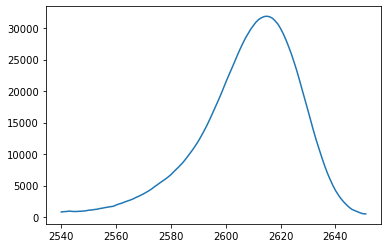

In [930]:
x = ch3b.intensity.loc[2540:2651,3].index
y = ch3b.intensity.loc[2540:2651,3] - 25000
plt.plot(x,y)

In [933]:
params = gmodel.make_params(center=2615, amplitude=ch3b.intensity.loc[2615,3], sigma=1, gamma=0.1)

In [934]:
result = gmodel.fit(y, params, x=x)

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

In [923]:
result

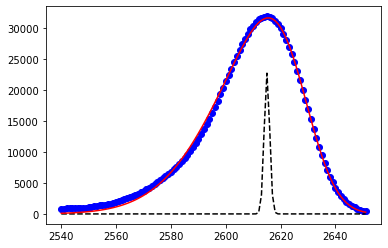

In [924]:
plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(x, result.best_fit, 'r-', label='best fit')